# **Lab 1: Viscous flow**
**Jacob Wahlgren**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://kth.instructure.com/courses/17071)

# **About the code**

In [1]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)
# Copyright (C) 2021 Jacob Wahlgren (jacobwah@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [2]:
import numpy as np
import time

import dolfin
from dolfin import *
from mshr import *
import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0$

together with suitable boundary conditions.

Here we present a FEniCS implementation of two mixed finite element methods to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions.

To derive the weak form of the equations, multiply the momentum equation by $v\in V$ and the continuity equation by $q\in Q$, and then integrate over the domain $\Omega$ and use Green's formula
$
(\nabla p -\Delta u,v) = -(p,\nabla \cdot v) + (\nabla u, \nabla v) 
+ <pn - \nabla u\cdot n, v>_{\Gamma}
$

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) 
+ <pn - \nabla u\cdot n, v>_{\partial \Omega} = (f,v)$

for all test functions $(v,q) \in V\times Q$. 

$
(v,w) = \int_{\Omega} v\cdot w ~dx, \quad 
<v,w>_{\partial \Omega} = \int_{\partial \Omega} v\cdot w~ds
$

We divide the boundary into $\partial \Omega=\Gamma_D \cup \Gamma_N$, with the different boundary conditions

$
u = g_D,\quad x\in \Gamma_D,
$

$
-\nu \nabla u\cdot n + pn = g_N, \quad x\in \Gamma_N,
$

For $x\in \Gamma_D$ the test function $v=0$. Hence, with $g_N=0$ the boundary term is zero. 

The equations can be expressed in residual form

$r(u,p;v,q) = - (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) - (f,v)$

We use inf-sup stable Taylor-Hood approximation spaces, 
and to implement the velocity boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, with $C>0$ a constant and $h$ the local mesh size. At outflow we use a "do nothing" stress free boundary condition. Additionally we show a solution in the inf-sup unstable equal order interpolation approximation spaces.


# **Method**

**Define domain and mesh**

The domain $\Omega$ is the rectangle with vertices $(0,0)$ and $(4,2)$, where a circle in the middle with radius 0.2 has been removed. The mesh has size $h=\frac{1}{32}$, but is refined in a radius of 1 around the midpoint of the circle.

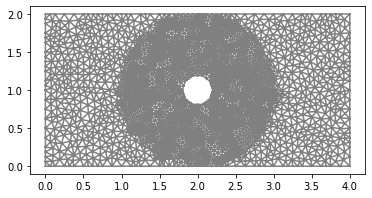

In [3]:
# Define rectangular domain 
L = 4
H = 2

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(L/2,H/2),0.2), resolution)
#mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(1.5,0.25*H),0.2) - Circle(Point(0.5,0.5*H),0.2) - Circle(Point(2.0,0.75*H),0.2), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 1
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(L/2, H/2)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

We have two approximation spaces, space 1 has equal order interpolation and space 2 is a Taylor-Hood space.

In [4]:
# Generate mixed finite element spaces (for velocity and pressure)
VE1 = VectorElement("CG", mesh.ufl_cell(), 1)
VE2 = VectorElement("CG", mesh.ufl_cell(), 2)

QE = FiniteElement("CG", mesh.ufl_cell(), 1)
Q = FunctionSpace(mesh, QE)

def spaces(VE):
    WE = VE * QE

    W = FunctionSpace(mesh, WE)
    V = FunctionSpace(mesh, VE)

    # Define trial and test functions
    w = Function(W)
    (u, p) = (as_vector((w[0], w[1])), w[2])
    (v, q) = TestFunctions(W)
    
    return WE, W, V, w, u, p, v, q

WE1, W1, V1, w1, u1, p1, v1, q1 = spaces(VE1)
WE2, W2, V2, w2, u2, p2, v2, q2 = spaces(VE2)

**Define boundary conditions**

The sign of the first component of `uin` determines which direction the flow has. Here the flow is changed so it goes from left to right by making the flow at the boundary go in the negative $x$ direction.

In [5]:
# Examples of inflow and outflow conditions
XMIN = 0.0; XMAX = L
YMIN = 0.0; YMAX = H

def in_out(V):
    uin = Expression(("-4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 
    #pout = 0.0

    # Inflow boundary (ib), outflow boundary (ob) and wall boundary (wb)
    ib = Expression("near(x[0],XMAX) ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q.ufl_element())
    #ob = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element()) 
    wb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q.ufl_element())
    
    return uin, ib, wb

uin1, ib1, wb1 = in_out(V1)
uin2, ib2, wb2 = in_out(V2)

# **Results**

**Define and solve variational problem**

In [6]:
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

def solve_variational(V, w, u, p, v, q, uin, ib, wb):
    f = Expression(("0.0","0.0"), element = V.ufl_element())

    # Define variational problem on residual form: r(u,p;v,q) = 0
    residual = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx + 
                gamma*(ib*inner(u - uin, v) + wb*inner(u, v))*ds - inner(f, v)*dx )

    # Solve algebraic system 
    solve(residual == 0, w)
    
solve_variational(V1, w1, u1, p1, v1, q1, uin1, ib1, wb1)
solve_variational(V2, w2, u2, p2, v2, q2, uin2, ib2, wb2)

**Visualize solution**

In [7]:
u11 = project(u1, V1)
p11 = project(p1, Q)
u12 = project(u2, V2)
p12 = project(p2, Q)

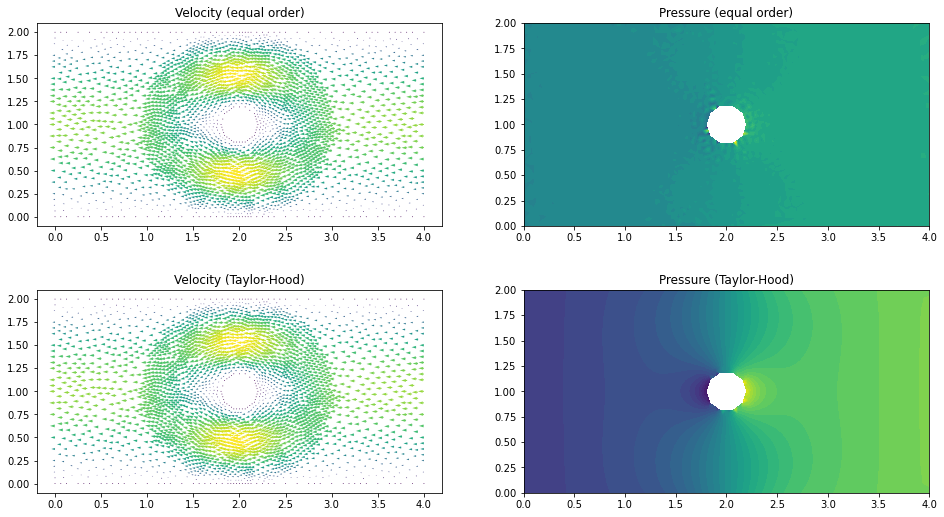

In [8]:
# Plot solution
fig, ((a, b), (c, d)) = plt.subplots(2, 2, figsize=(16,9))

plt.sca(a)
plot(u11, title="Velocity (equal order)")
plt.sca(b)
plot(p11, title="Pressure (equal order)")
plt.sca(c)
plot(u12, title="Velocity (Taylor-Hood)")
plt.sca(d)
plot(p12, title="Pressure (Taylor-Hood)")

# **Discussion**

Taylor-Hood and equal order interpolation mixed finite element methods were implemented in FEniCS to solve the Stokes equations in 2D. The methods were tested for the model problem of flow past a circular obstacle. The velocity solution diagram for both implementations look as expected. Since equal order interpolation does not satisfy the inf-sup condition, the pressure solution is unstable and does not look as expected. The pressure should be continuous and highest in front of the cylinder, like in the Taylor-Hood solution, while the equal order solution is not smooth. The fact that the pressure is high on the right side and low on the left side shows that the flow direction is right-to-left.